# Features

These features help catch the lure phase of spearphishing attack.As we detect the name and address spoofing in python and mysql database with the help of unique function.

So here we use the emails features like from, to and body and do unsupervised machine learning with the help of clustering methods to find "outliers".

In [28]:

# extracting parts from email
def parse_raw_email(raw_message):
    lines=raw_message.split('\n')
    email = {}
    message =''
    
    keys_to_extract = ['from','to']
    for line in lines:
        if ':' not in line:
            message +=line.strip()
            email['body'] =message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email

def parse_into_emails(messages):
    emails = [parse_raw_email(message) for message in messages]
    return {
        'body' : map_to_list(emails,'body'),
        'to' : map_to_list(emails,'to'),
         'from_' : map_to_list(emails,'from')
    }
#storing result in hashmap
def map_to_list(emails,key):
    results=[]
    for email in emails:
        if key not in email:
            results.append('')
        else:
            results.append(email[key])
    return results        


In [29]:

import pandas as pd
emails = pd.read_csv('split_emails.csv')
print emails.shape

(10000, 3)


## Content Features & Previously seen attacker

Now here we use the content of the email and characterize them if they likely to cause phishing or not. So the detection is also taking into account the to and from attributes we are able to find and cluster which set of names were attacked(victim) and the person who usually cause the attack(attackers).


How we do that is, we take the email as a whole document and in that we take 3 kinds of cluster based on to, from and body. Then we come to know who are those usual "to" (the victims),"from" (attackers) and "body" (keywords only) as we use the term frequency library it tells us which names and which keywords were used in the phishing email.

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import normalize 


In [31]:
email_df = pd.DataFrame(parse_into_emails(emails.message))

In [32]:
email_df.drop(email_df.query("body == '' | to == '' | from_ == ''").index,inplace=True)

In [33]:
vect=TfidfVectorizer(stop_words='english',max_df=0.50,min_df=2)
X=vect.fit_transform(email_df.body)

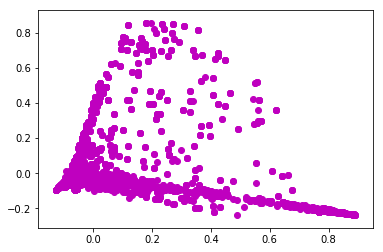

In [34]:
X_dense = X.todense()
coords = PCA(n_components=2).fit_transform(X_dense)
plt.scatter(coords[:,0],coords[:,1],c='m')
plt.show()

In [36]:
import numpy as np
import matplotlib.pyplot as plt

### Here we have the scoring for each of the attributes noted above

In [57]:
def top_tfidf_features(row,features,top_n=20):
    topn_ids=np.argsort(row)[::-1][:top_n]
    top_feats=[(features[i],row[i]) for i in topn_ids]
    df=pd.DataFrame(top_feats,columns=['features','score'])
    return df


def top_features_in_doc(X,features,row_id,top_n=25):
    row=np.squeeze(X[row_id].toarray())
    return top_tfidf_features(row,features,top_n)

def top_mean_features(X,features,grp_ids=None,min_tfidf=0.1,top_n=25):
    if grp_ids:
        D=X[grp_ids].toarray()
    else:
        D=X.toarray()

    D[D < min_tfidf] =0 
    tfidf_means=np.mean(D,axis=0)
    return top_tfidf_features(tfidf_means,features,top_n)

def top_features_per_cluster(X,y,features,min_tfidf=0.1,top_n=25):
    labels=np.unique(y)
    dfs=[]
    for label in labels:
        ids=np.where(y==label)
        features_df = top_mean_features(X,features,ids,min_tfidf=min_tfidf,top_n=top_n)
        features_df.label=label
        dfs.append(features_df)
    return dfs    


def plot_tfidf_classfeatures_h(dfs):
    fig=plt.figure(figsize=(12,9),facecolor="w")
    x=np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax= fig.add_subplot(1,len(dfs),i+1)
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tfidf score",labelpad=16,fontsize=14)
        ax.set_title("Cluster labels ="+str(df.label),fontsize=16)
        ax.ticklabel_format(axis='x',style='sci',scilimits=(-2,2))
        ax.barh(x,df.score,align='center',color='#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1,x[-1]+1])
        yticks=ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09,right=0.97,left=0.15,top=0.95,wspace=0.52)
    plt.show()    

#### Clustering based on score and here we find out the most occuring words in phishing 

In [52]:
n_clusters=3
clf=KMeans(n_clusters=n_clusters,max_iter=100,init='k-means++',n_init=1)
labels=clf.fit_predict(X)

In [40]:
X_dense=X.todense()
pca=PCA(n_components=2).fit(X_dense)
coords=pca.transform(X_dense)

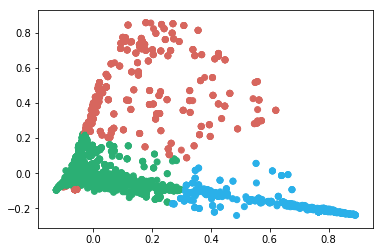

In [41]:
label_colors=["#2AB0E9","#2BAF74","#D7665E","#CCCCCC","#D2CA0D","#522A64","#A3DB05","#FC6514"]
colors = [label_colors[i] for i in labels]
plt.scatter(coords[:,0],coords[:,1],c=colors)


In [42]:
centroids = clf.cluster_centers_
cetroid_coords= pca.transform(centroids)

In [ ]:
centroid_coords

In [45]:
features=vect.get_feature_names()

In [ ]:
features

### These are the words and names found in the Phishing emails as per enron dataset

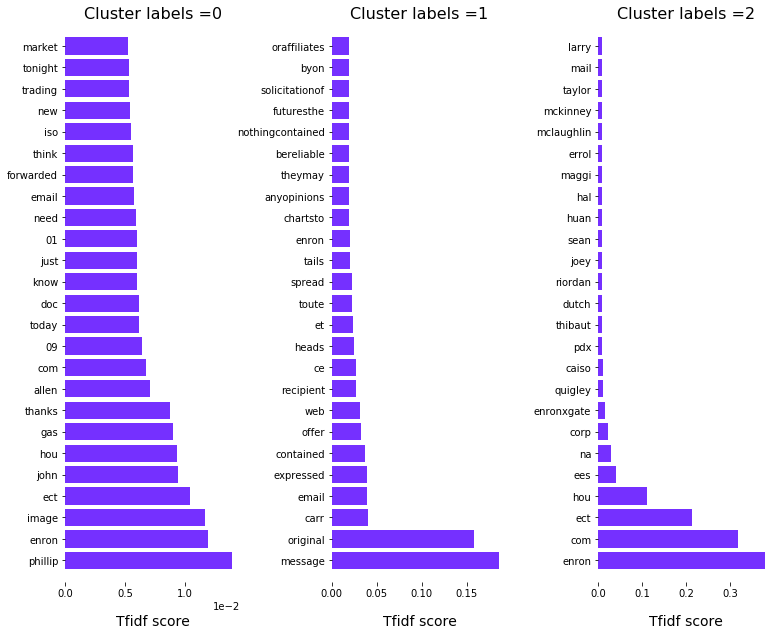

In [58]:
plot_tfidf_classfeatures_h(top_features_per_cluster(X,labels,features,0.1,25))